# Implementation of a CNN based Image Classifier using PyTorch

Downloading data and printing some sample images from the training set

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


(-0.5, 145.5, 145.5, -0.5)

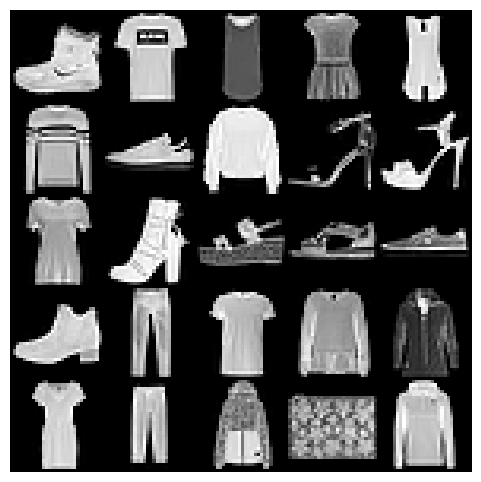

In [41]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np


# The below two lines are optional and are just there to avoid any SSL
# related errors while downloading the CIFAR-10 dataset
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


#Defining plotting settings
plt.rcParams['figure.figsize'] = 14, 6


#Initializing normalizing transform for the dataset
normalize_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,))
])


#Downloading the FashionMNIST dataset into train and test sets


train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=normalize_transform,
    download=True
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    transform=normalize_transform,
    download=True
)
print(train_dataset)
print(test_dataset)



#Generating data loaders from the corresponding datasets
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


#Plotting 25 images from the 1st batch
dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.imshow(np.transpose(torchvision.utils.make_grid(
images[:25], normalize=True, padding=1, nrow=5).numpy(), (1, 2, 0)))
plt.axis('off')



Plotting class distribution of the dataset

Text(0, 0.5, 'Number of training instances')

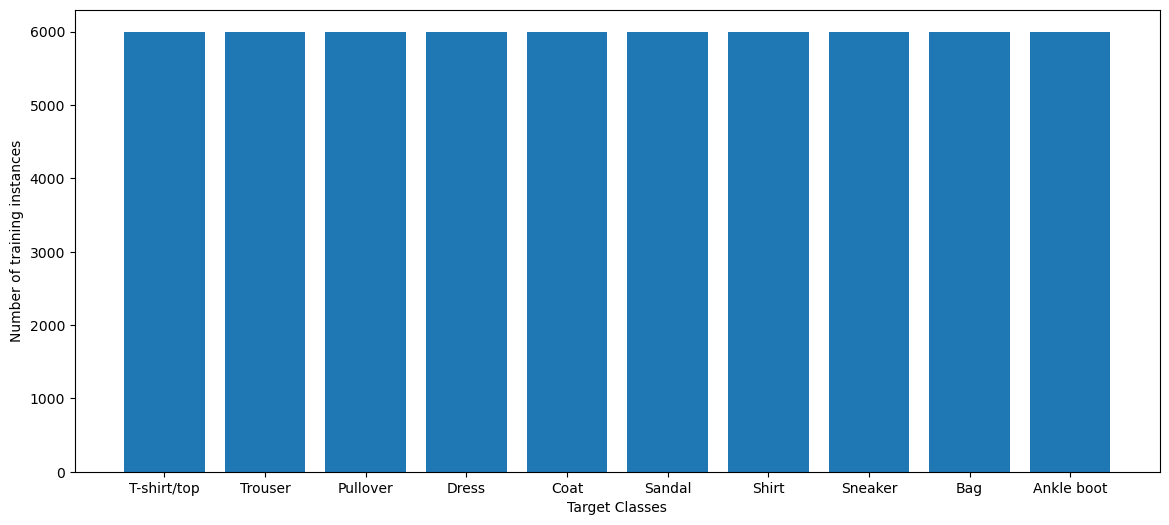

In [42]:
#Iterating over the training dataset and storing the target class for each sample
classes = []
for batch_idx, data in enumerate(train_loader, 0):
	x, y = data
	classes.extend(y.tolist())
	
#Calculating the unique classes and the respective counts and plotting them
unique, counts = np.unique(classes, return_counts=True)
names = list(test_dataset.class_to_idx.keys())
plt.bar(names, counts)
plt.xlabel("Target Classes")
plt.ylabel("Number of training instances")

 Implementing the CNN architecture with removing Conv2d, ReLU layers.

In [43]:
class CNN(torch.nn.Module):
	def __init__(self):
		super().__init__()
		self.model = torch.nn.Sequential(
            
            
			#Input = 1 x 28 x 28, Output = 32 x 28 x 28
			torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
			torch.nn.ReLU(),
			#Input = 32 x 28 x 28, Output = 32 x 14 x 14
			torch.nn.MaxPool2d(kernel_size=2),

			#Input = 32 x 14 x 14, Output = 64 x 14 x 14
			torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
			torch.nn.ReLU(),
			#Input = 64 x 14 x 14, Output = 64 x 7 x 7
			torch.nn.MaxPool2d(kernel_size=2),
            
            

			#Input = 64 x 7 x 7, Output = 128 x 7 x 7
			torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
			torch.nn.ReLU(),
			#Input = 128 x 7 x 7, Output = 128 x 3 x 3
			torch.nn.MaxPool2d(kernel_size=2),

			torch.nn.Flatten(),
			torch.nn.Linear(128 * 3 * 3, 512),
			torch.nn.ReLU(),
			torch.nn.Linear(512, 10)
            

		)

	def forward(self, x):
		return self.model(x)

Defining the training parameters and beginning the training process

Epoch 1/10: Training loss = 0.6858297149255586
Epoch 2/10: Training loss = 0.4790012387832853
Epoch 3/10: Training loss = 0.42983509962365574
Epoch 4/10: Training loss = 0.4036899660823188
Epoch 5/10: Training loss = 0.38725589390502557
Epoch 6/10: Training loss = 0.3759850684259492
Epoch 7/10: Training loss = 0.3671678291010196
Epoch 8/10: Training loss = 0.3600924234591059
Epoch 9/10: Training loss = 0.3542242176306527
Epoch 10/10: Training loss = 0.3494821182890996


Text(0, 0.5, 'Training loss')

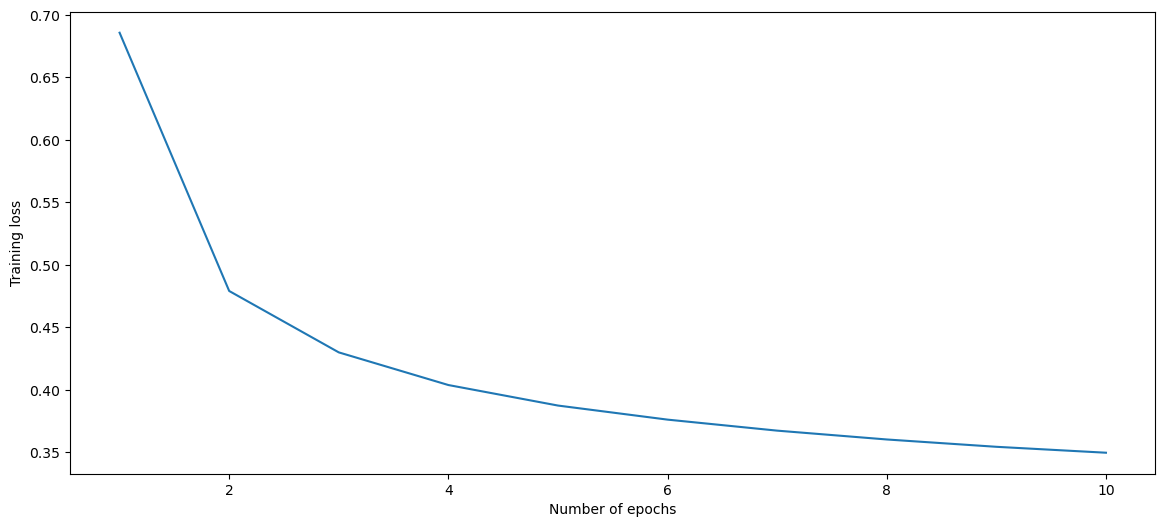

In [44]:
#Selecting the appropriate training device
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import MultiStepLR


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

#Defining the model hyper parameters
num_epochs = 10
learning_rate = 0.001
weight_decay = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

scheduler = MultiStepLR(optimizer, 
                        milestones=[4, 7], # List of epoch indices
                        gamma =0.5) # Multiplicative factor of learning rate decay

#Training process begins
train_loss_list = []
for epoch in range(num_epochs):
	print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
	train_loss = 0
	
	#Iterating over the training dataset in batches
	model.train()
	for i, (images, labels) in enumerate(train_loader):
		
		#Extracting images and target labels for the batch being iterated
		images = images.to(device)
		labels = labels.to(device)

		#Calculating the model output and the cross entropy loss
		outputs = model(images)
		loss = criterion(outputs, labels)

		#Updating weights according to calculated loss
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		scheduler.step()
		train_loss += loss.item()
	
	#Printing loss for each epoch
	train_loss_list.append(train_loss/len(train_loader))
	print(f"Training loss = {train_loss_list[-1]}")
	
#Plotting loss for all epochs
plt.plot(range(1,num_epochs+1), train_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")


Calculating the model’s accuracy on the test set

In [45]:
test_acc=0
model.eval()

with torch.no_grad():
	#Iterating over the training dataset in batches
	for i, (images, labels) in enumerate(test_loader):
		
		images = images.to(device)
		y_true = labels.to(device)
		
		#Calculating outputs for the batch being iterated
		outputs = model(images)
		
		#Calculated prediction labels from models
		_, y_pred = torch.max(outputs.data, 1)
		
		#Comparing predicted and true labels
		test_acc += (y_pred == y_true).sum().item()
	
	print(f"Test set accuracy = {100 * test_acc / len(test_dataset)} %")



Test set accuracy = 85.55 %


Generating predictions for sample images in the test set

(-0.5, 145.5, 29.5, -0.5)

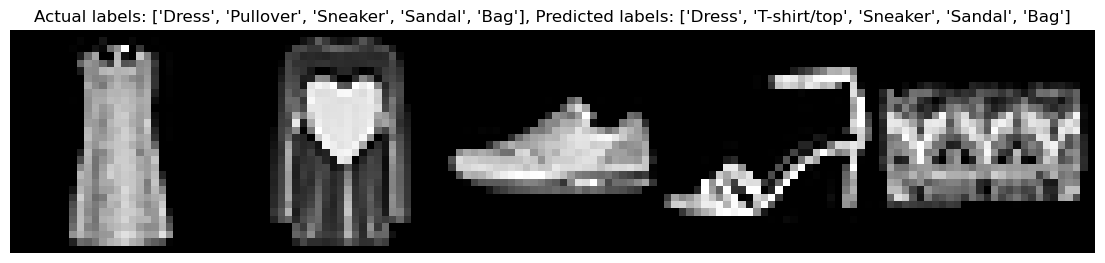

In [46]:
#Generating predictions for 'num_images' amount of images from the last batch of test set
num_images = 5
y_true_name = [names[y_true[idx]] for idx in range(num_images)]
y_pred_name = [names[y_pred[idx]] for idx in range(num_images)]

#Generating the title for the plot
title = f"Actual labels: {y_true_name}, Predicted labels: {y_pred_name}"

#Finally plotting the images with their actual and predicted labels in the title
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:num_images].cpu(), normalize=True, padding=1).numpy(), (1, 2, 0)))
plt.title(title)
plt.axis("off")

